In [53]:
%pwd
%cd template
%pwd

[Errno 2] No such file or directory: 'template'
/mnt/d/src/learn-ml/template


'/mnt/d/src/learn-ml/template'

# Base

In [54]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import set_config
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from category_encoders import MEstimateEncoder

# Constants
data_file_path = "./data/home-data-for-ml-course/train.csv"
test_size = 0.2
val_size = 0.2
random_state = 0
set_config(transform_output="pandas")

# Load data
df = pd.read_csv(data_file_path)

# Target and features
target = "SalePrice"
y = df.SalePrice

# All numeric without missing values
features = list(set(df.columns) - set(["SalePrice"]))
X_orig = df[features]
X = X_orig.copy()

seed = 0 # for random operations

# Preprocessing

In [55]:
# Numerical vs categorical features
categorical_cols = list(X.select_dtypes(include=["object"]).columns)
numerical_cols = list(set(X.columns) - set(categorical_cols))
area_cols = ["LotFrontage","LotArea","MasVnrArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","GrLivArea","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea"]

In [56]:
# Handle missing values by replacing with mean or mode
cols_with_missing_vals = X.isnull().sum()
cols_with_missing_vals = cols_with_missing_vals[cols_with_missing_vals > 0].index

cols_with_missing_vals_categorical = list(set(categorical_cols).intersection(set(cols_with_missing_vals)))
cols_with_missing_vals_numerical = list(set(numerical_cols).intersection(set(cols_with_missing_vals)))

# Mask numerical nulls with mean
for col in cols_with_missing_vals_numerical:
    print(f"Replacing nulls in {col} with mean")
    X[col] = X[col].mask(X[col].isnull(), X[col].mean())

# Mask categorical nulls with mode
for col in cols_with_missing_vals_categorical:
    print(f"Replacing nulls in {col} with mode")
    X[col] = X[col].mask(X[col].isnull(), X[col].mode().values[0])

assert np.all(X.isnull().sum() == 0), "Null values are still present in the data"

Replacing nulls in MasVnrArea with mean
Replacing nulls in LotFrontage with mean
Replacing nulls in GarageYrBlt with mean
Replacing nulls in BsmtExposure with mode
Replacing nulls in MasVnrType with mode
Replacing nulls in GarageCond with mode
Replacing nulls in BsmtQual with mode
Replacing nulls in GarageQual with mode
Replacing nulls in FireplaceQu with mode
Replacing nulls in Fence with mode
Replacing nulls in GarageType with mode
Replacing nulls in PoolQC with mode
Replacing nulls in BsmtFinType2 with mode
Replacing nulls in GarageFinish with mode
Replacing nulls in Alley with mode
Replacing nulls in MiscFeature with mode
Replacing nulls in BsmtCond with mode
Replacing nulls in Electrical with mode
Replacing nulls in BsmtFinType1 with mode


In [57]:
# Ordinal-encode categorical variables
# pd.options.mode.chained_assignment = None

for col in categorical_cols:
    values, index = pd.factorize(X.loc[:, col])
    # Disable chained assignment for this line
    X[col] = values

# pd.options.mode.chained_assignment = "warn"

In [58]:
# Standardize all numerical features
cols = numerical_cols
X[cols] = (X[cols] - X[cols].mean()) / X[cols].std()

# Feature Importance

In [59]:
# Use mutual information to select features
from sklearn.feature_selection import mutual_info_regression

# Compute mutual information scores
mi_scores = pd.Series(
    data=mutual_info_regression(X[numerical_cols], y, discrete_features=False),
        index=numerical_cols)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

OverallQual      0.564778
GrLivArea        0.480611
TotalBsmtSF      0.367638
YearBuilt        0.367318
GarageArea       0.357219
GarageCars       0.353324
1stFlrSF         0.310173
GarageYrBlt      0.293663
MSSubClass       0.268709
FullBath         0.251009
YearRemodAdd     0.248603
TotRmsAbvGrd     0.218951
2ndFlrSF         0.203335
LotFrontage      0.195245
Fireplaces       0.177409
LotArea          0.157476
OpenPorchSF      0.154329
BsmtFinSF1       0.149031
OverallCond      0.121625
BsmtUnfSF        0.119046
WoodDeckSF       0.111522
MasVnrArea       0.098613
HalfBath         0.084532
BedroomAbvGr     0.067579
ScreenPorch      0.025924
KitchenAbvGr     0.022755
BsmtFullBath     0.021293
EnclosedPorch    0.021061
BsmtHalfBath     0.006435
3SsnPorch        0.006178
BsmtFinSF2       0.003966
LowQualFinSF     0.002294
PoolArea         0.000000
MiscVal          0.000000
YrSold           0.000000
Id               0.000000
MoSold           0.000000
dtype: float64

<Axes: ylabel='None'>

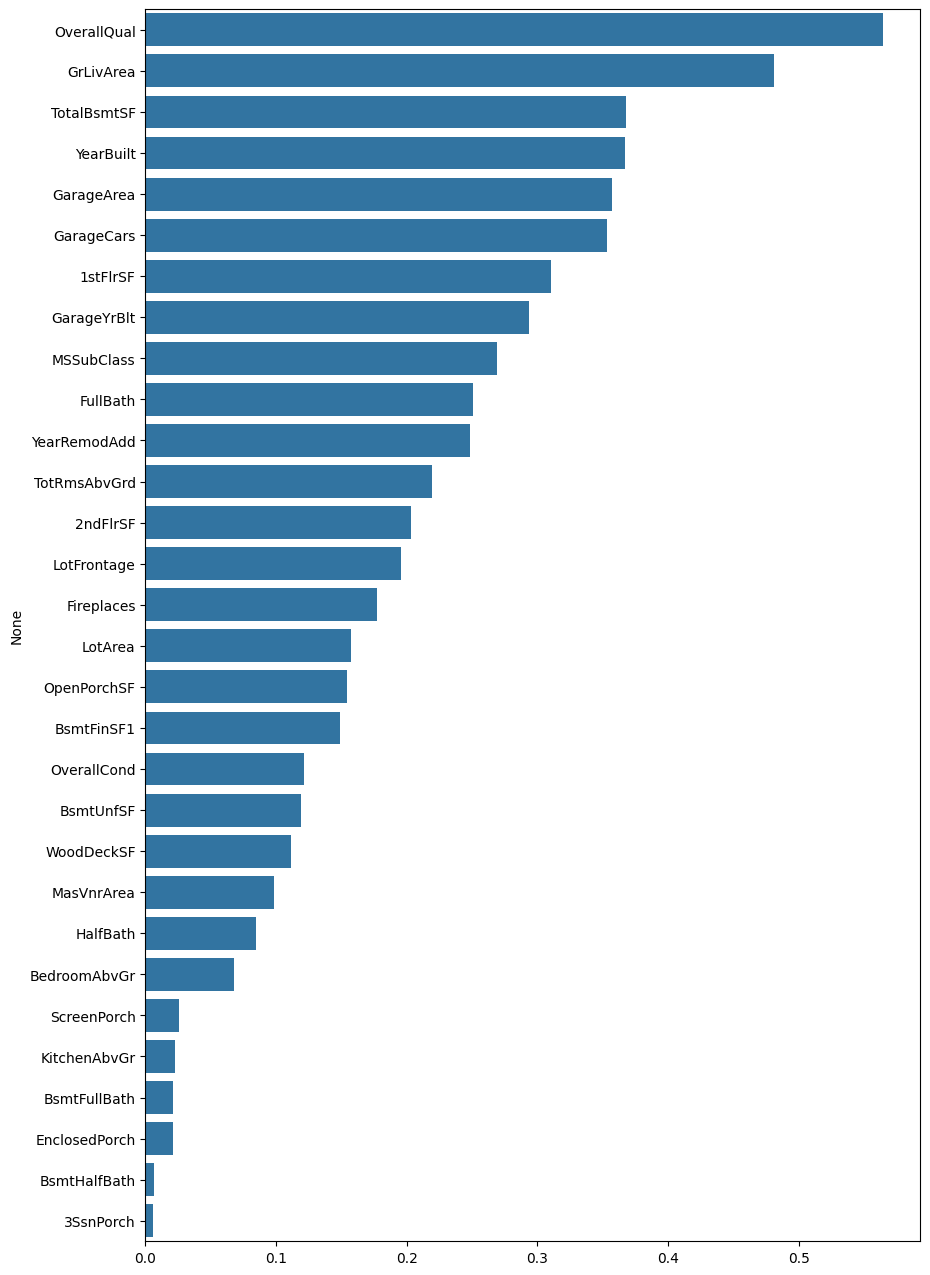

In [60]:
# Plot mutual information scores
import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10,16))
N = 30
sns.barplot(x=mi_scores.values[0:N], y=mi_scores.index[0:N])

# Creating Features

In [61]:
# Create some features
# LotFrontage: Linear feet of street connected to property
# LotArea: Lot size in square feet
# MasVnrArea: Masonry veneer area in square feet
# # BsmtFinSF1: Type 1 finished square feet
# BsmtFinSF2: Type 2 finished square feet
# BsmtUnfSF: Unfinished square feet of basement area
# TotalBsmtSF: Total square feet of basement area
# 1stFlrSF: First Floor square feet
# 2ndFlrSF: Second floor square feet
# LowQualFinSF: Low quality finished square feet (all floors)
# GrLivArea: Above grade (ground) living area square feet
# BsmtFullBath: Basement full bathrooms
# BsmtHalfBath: Basement half bathrooms
# FullBath: Full bathrooms above grade
# HalfBath: Half baths above grade
# Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
# Kitchen: Kitchens above grade
# TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
# Fireplaces: Number of fireplaces
# GarageCars: Size of garage in car capacity
# GarageArea: Size of garage in square feet
# WoodDeckSF: Wood deck area in square feet
# OpenPorchSF: Open porch area in square feet
# EnclosedPorch: Enclosed porch area in square feet
# 3SsnPorch: Three season porch area in square feet
# ScreenPorch: Screen porch area in square feet
# PoolArea: Pool area in square feet
# MiscVal: $Value of miscellaneous feature
cols = ["LotArea","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","TotalBsmtSF","1stFlrSF","2ndFlrSF","LowQualFinSF","GrLivArea","BsmtFullBath","BsmtHalfBath","FullBath","HalfBath","TotRmsAbvGrd","Fireplaces","GarageCars","GarageArea","WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch","ScreenPorch","PoolArea","MiscVal"]
N = len(cols)
for m in range(N):
    for n in range(m + 1, N):
        X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)

# The above transform divides one feature by another. Other possible transforms:
# logs, counts, splitting or combining string features, a grouped feature that
# the sample belongs to

/tmp/ipykernel_6040/1648094331.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)
/tmp/ipykernel_6040/1648094331.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{cols[m]}/{cols[n]}"] = (X[cols[m]]/X[cols[n]]).fillna(value=0).replace(np.inf, 0)
/tmp/ipykernel_6040/1648094331.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Conside

# Cluster Labels as Features

In [62]:
# Use k-means to create cluster labels and use these as a feature
kmeans = KMeans(n_clusters=5, random_state=0, n_init="auto", max_iter=300).fit(X[["GrLivArea","TotalBsmtSF"]])
X["cluster"] = kmeans.predict(X[["GrLivArea","TotalBsmtSF"]])

In [63]:
# Could use the distance to cluster centroids as a feature as well
kmeans.transform(X[["GrLivArea","TotalBsmtSF"]])

,kmeans0,kmeans1,kmeans2,kmeans3,kmeans4
0,1.288956,2.825708,1.052217,0.426020,1.634366
1,0.725078,3.093017,1.610322,1.465883,0.990008
2,1.404282,2.620508,1.257065,0.251557,1.511026
3,1.375485,2.975631,0.932080,0.542933,1.862568
4,2.204136,1.702551,2.188563,0.731648,1.452609
...,...,...,...,...,...
1455,1.133311,2.774771,1.131889,0.519755,1.406395
1456,2.305152,1.430906,2.696905,1.437003,0.847279
1457,2.473724,1.520113,2.416604,0.955257,1.654584
1458,0.193298,3.570365,1.256466,1.636240,1.535030


# PCA for Feature Engineering

In [64]:
def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs

In [65]:
# PCA basics
# Always standardize data for PCA
pca = PCA()
cols = area_cols
X_pca = pca.fit_transform(X[cols]) # the data transformed by PCA; each column is a principal component

# pca.components_; each row is a principal component, each column is a feature
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = cols)

# pc0 represent lots with high LotFrontage and high LotArea
# pc1 represent lots with low LotFrontage and high LotArea, eg, narrow lots

# Explained variante ratio
df_ev = pd.DataFrame(data = pca.explained_variance_ratio_,
                     index = df_pca_comp.index,
                     columns = ["ev"])
# Each row is the fraction of variance explained by the corresponding principal component
# pc0 explains 23.4% of the variance

df_ev

,ev
0,0.234406
1,0.104290
2,0.089014
3,0.072869
4,0.065243
5,0.061751
6,0.058472
7,0.053911
8,0.050810
9,0.050216


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

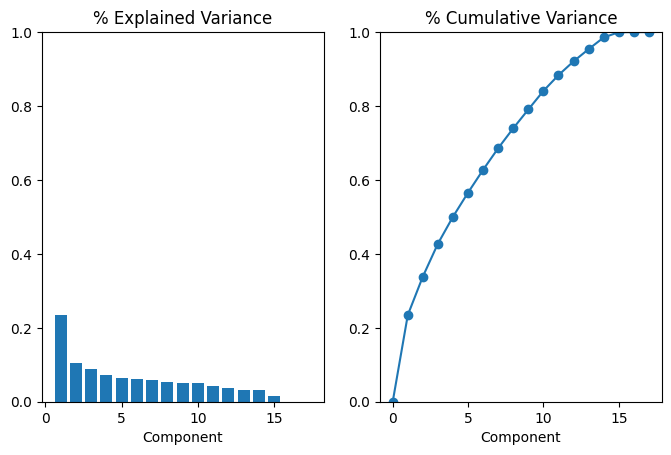

In [66]:
plot_variance(pca)

In [67]:
mi_scores = pd.Series(
    data=mutual_info_regression(X_pca, y, discrete_features=False),
        index=X_pca.columns)
mi_scores = mi_scores.sort_values(ascending=False)
mi_scores

# component 0 has a high mutual information score, so it can be used as a feature as-is


pca0     0.710202
pca1     0.152119
pca2     0.142678
pca14    0.076554
pca5     0.073630
pca8     0.058965
pca10    0.054897
pca6     0.049932
pca3     0.045106
pca13    0.038741
pca11    0.038134
pca4     0.037517
pca9     0.034944
pca12    0.029741
pca7     0.026303
pca15    0.019420
pca16    0.010593
dtype: float64

In [68]:
# Sort the absolute value of loadings of component 0
# Loadings that have high absolute values can be used to create new features (products, ratios, etc.)
df_pca_comp.loc[0,:].abs().sort_values(ascending=False)

1stFlrSF         0.419966
TotalBsmtSF      0.415341
GrLivArea        0.380858
GarageArea       0.347815
LotFrontage      0.280083
MasVnrArea       0.271106
BsmtFinSF1       0.257733
LotArea          0.212476
OpenPorchSF      0.195991
WoodDeckSF       0.185052
BsmtUnfSF        0.138979
PoolArea         0.109961
2ndFlrSF         0.086631
EnclosedPorch    0.066874
ScreenPorch      0.065650
3SsnPorch        0.028604
BsmtFinSF2       0.020152
Name: 0, dtype: float64

In [69]:
# Create a Boxen plot (sns.catplot) of the principal components to see outliers

# Target Encoding
Encode categorical variables using a number derived from the target. Known by
other names as mean encoding, bin counting, likelihood encoding, impact
encoding, leave-one-out encoding

In [70]:
# Good candidates for target encoding features are categorical features with
# high cardinality; categorical features with a lot of unique values
X = X_orig.copy()
X = X.drop(["Id"], axis=1)
unq_cnts = X.loc[:, categorical_cols]\
    .nunique().sort_values(ascending=False)
cols_to_target_encode = list(unq_cnts[unq_cnts >= 10].index)

In [71]:
# For a given categorical feature, find the frequency with which a unique value
# occurs.
# It is useful to see this when target encoding to evaluate rare categories and
# determine if smoothing is needed or not
for col in cols_to_target_encode:
    print(X[col].value_counts())

NAmes      225
CollgCr    150
OldTown    113
Edwards    100
Somerst     86
Gilbert     79
NridgHt     77
Sawyer      74
NWAmes      73
SawyerW     59
BrkSide     58
Crawfor     51
Mitchel     49
NoRidge     41
Timber      38
IDOTRR      37
ClearCr     28
StoneBr     25
SWISU       25
MeadowV     17
Blmngtn     17
BrDale      16
Veenker     11
NPkVill      9
Blueste      2
Name: Neighborhood, dtype: int64
VinylSd    504
MetalSd    214
HdBoard    207
Wd Sdng    197
Plywood    142
CmentBd     60
Wd Shng     38
Stucco      26
BrkFace     25
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        5
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64
VinylSd    515
HdBoard    222
MetalSd    220
Wd Sdng    206
Plywood    108
CemntBd     61
BrkFace     50
WdShing     26
Stucco      25
AsbShng     20
BrkComm      2
Stone        2
AsphShn      1
ImStucc      1
CBlock       1
Name: Exterior1st, dtype: int64


In [72]:
# Split X into encoding, test, training, and validation sets
X_encode = X.sample(frac=0.2, random_state=seed)
y_encode = y[X_encode.index]
X = X.drop(X_encode.index)
y = y.drop(y_encode.index)

X_test = X.sample(frac=0.2, random_state=seed)
y_test = y[X_test.index]
X = X.drop(X_test.index)
y = y.drop(y_test.index)

X_train = X.sample(frac=0.8, random_state=seed)
y_train = y[X_train.index]
X_valid = X.drop(X_train.index)
y_valid = y.drop(y_train.index)

In [76]:
enc = MEstimateEncoder(cols=cols_to_target_encode, m=5)
enc.fit(X_encode, y_encode)
X_train = enc.transform(X_train, y_train)